# Search-Based Matching algorithm

Dominika Tkaczyk

22.11.2018

This file contains the analysis of the search-based matching algorithms (SBM and SBMV).

**SBM (Search-Based Matching)** is a very simple algorithm, based on the search functionality of Crossref REST API. It uses the search engine to find the target document for the given bibliographic reference string. The entire reference string is used as a query in the search engine. SBM returns the first hit from the results list, if its relevance score is high enough. If the relevance score of the first hit is low, null value is returned and the reference string stays unmatched.

The meta-parameters of SBM are the type and value of the relevance score threshold (i.e. how we decide whether the top hit should be returned or not).

**SBMV (Search-Based Matching with Validation)** is a variation of SBM, in which we use an additional validation procedure. First, simple SBM is applied and a number of top results are selected as candidate target documents. Second, during the validation we re-score the candidates using the validation similarity, calculated for the input string and each candidate. The validation similarity is based on the presence of candidate document's metadata fields (year, volume, issue, pages, the lastname of the first author, etc.) in the input reference string, as well as the relevance score returned by the search engine. Finally, the most similar candidate is chosen as the final target document, if its similarity is high enough. If the highest similarity is low, null value is returned and the reference string stays unmatched.

The meta-parameters of SBMV are the type and value of the relevance threshold used to select the candidates (i.e. how many candidates we select from the results), as well as the validation similarity threshold (i.e. how we decide whether the most similar candidate should be returned).

The goal of this analysis is to compare SBM and SBMV and find good values of the meta-parameters.

## TL;DR

  * I used two datasets: a dataset with automatically generated reference strings and a semi-manually annotated dataset containing reference strings from the live system.
  * I investigated the tradeoff between [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall). The best value of a threshold is always chosen as the one maximizing the overall [F1](https://en.wikipedia.org/wiki/F1_score). F1 is a standard metric that combines precision and recall into a single number, weighing them equally.
  * I tested three variants of the matching algorithm:
    * **SBM with a simple threshold** (comparing the relevance score with a single number)
    * **SBM with a normalized threshold** (comparing the relevance score divided by the length of the reference string with a single number)
    * **SBMV** with a fixed normalized threshold of 0.4 for selecting the candidates and **a validation threshold** for choosing the final result
  * The best value of the simple threshold for SBM is 54 for the automatically generated strings and 64 for the real dataset.
  * The best value of the normalized threshold for SBM is 0.47 for the automatically generated strings and 0.4 for the real dataset.
  * The best value of the validation threshold for SBMV is 0.56 for the automatically generated strings and 0.34 for the real dataset. The large difference in this case can be explained by increased noise in the real dataset (with more differences between the reference string and the metadata records, we need to be more tolerant when we compare the reference string with the candidates).
  * **Using the normalized threshold is the better choice for SBM**: the best normalized threshold outperforms the best simple threshold in overall F1 (72.7% vs. 69.0% for automatically generated strings and 90.0% vs. 86.0% for the real dataset), as well as F1 for each citation style.
  * **SBMV with the best validation threshold outperforms SBM with the best normalized threshold** in overall F1 (82.5% vs. 72.7% for automatically generated strings and 96.3% vs. 90.0% for the real dataset), as well as F1 for each citation style.

## Methodology

In the simplest approach, SBM compares the item's relevance score with the relevance score threshold, and the item is accepted if its score exceeds the threshold. Note that if the threshold is small, the algorithm will return more matches, some correct and some incorrect. As a result more true links will be discovered, but at the same time we will have more incorrect links (more false positives). On the other hand, if the score threshold is large, we will have fewer matches overall. This means fewer true links discovered (more false negatives), but also fewer incorrect links. We observe similar tradeoffs with other types of the thresholds.

To explore, how the type and the value(s) of the thresholds affect the quality, we will need two things: the metrics and the dataset.

### Metrics

The rate of false positives and false negatives can be controlled by precision and recall, respectively:
  * **precision** is the number of correct links divided by the number of links returned by the algorithm (equivalently: the probability that the link returned by the algorithm is correct)
  * **recall** is the number of correct links divided by the number of true links (equivalently: the probability that the true link will be returned by the algorithm)

There is a tradeoff between precision and recall: we can always have higher recall at the price of lower precision, and vice versa. A standard way to control this is by combining precision and recall into one metric: F-measure. F-measure lets us weigh precision and recall accordingly to our application. For example, if we decide that it is more important to have more links discovered and we are willing to pay for it with more incorrect links, we would weight precision and recall differently in F-measure. In these experiments, however, I assume precision and recall have the same importance. This balanced version of F-measure is called **F1**, and is a simple harmonic mean of precision and recall.

### Datasets

I used two datasets for the experiments.

The first dataset was build automatically in the following way:
  1. I selected two samples of items from the system, each of size 2500:
    * Sample #1 is a regular sample, and any reference string generated from a document in this sample is expected to be linked to the original document.
    * Sample #2 contains documents that we exclude (or rather pretend to exclude) from the collection. A reference string generated from a document in this sample is expected not to be linked to anything.
  
  To eliminate items with very poor metadata, the samples were randomly selected from a subset of items, for which at least one of the following conditions is true:
    * the item has at least three out of the following metadata fields: authors, title, year, volume, pages
    * the item has authors and year, OR
    * the item has title and year
  2. For each document in both samples, I generated the reference strings in 8 citation styles (*american-chemical-society*, *american-institute-of-physics*, *apa*, *chicago-author-date*, *elsevier-without-titles*, *harvard3*, *ieee*, *modern-language-association*). This resulted in 40,000 reference strings in total.
  3. I used SBM(V) algorithms to find target documents for each generated reference string. The algorithm works as described before, but it pretends not to see the documents from sample #2 in the results, so they are never returned. No threshold was applied at this point, but all relevance/validation scores were recorded, making it possible to modify the dataset later according to any filtering method.

Note that a more exact approach would be to build the search index without our "excluded" sample, instead of pretending they are not a part of the search results. This way we would be sure that the presence of these documents did not affect the scores in the system (especially the IDFs). On the other hand, it is unlikely that the absence of this sample will change the scores a lot.

The second dataset was created semi-automatically. The dataset is based on 1000 real reference strings sampled from 5k items from the live system. All reference strings were matched using both SBM(V) algorithms, as well as the current parsing-based algorithm (I used Simple Text Query form). The ground truth DOIs were assigned in the following way:
  * if DOIs returned by STQ and SBM are the same, I assume it is correct and assign it to the document as the ground truth DOI
  * if DOIs returned by STQ and SBM are different, both were inspected manually:
    * if one of them was correct, it was assigned to the document as the ground truth DOI
    * if none of them was correct, I assume no target DOI exists
  * if only SBM returned the DOI, it was manually verified:
    * if correct, it was assigned to the document as the ground truth DOI
    * if incorrect, I assume no target DOI exists

## Results

In [1]:
import sys
sys.path.append('..')

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import re
import utils.data_format_keys as dfk

from evaluation.link_metrics import LinkMetricsResults
from utils.utils import read_json, remote_call

DATA_DIR = '../data/sbm_analysis/'
STYLES = ['apa', 'american-chemical-society', 'american-institute-of-physics',
          'chicago-author-date', 'elsevier-without-titles', 'harvard3', 'ieee',
          'modern-language-association']
STYLES_ABR = ['apa', 'acs', 'aip', 'chicago', 'ewt', 'harvard', 'ieee', 'mla']

### Artificial dataset

#### SBM with a simple threshold

Let's start with the most basic version of the SBM algorithm. First, we will read the data:

In [2]:
def read_artificial_data(algorithm):
    data = []
    for style in STYLES:
        prefix = DATA_DIR + 'matched/matched-' + algorithm
        data.extend(read_json(prefix + '-' + style + '.json')[dfk.DATASET_DATASET])
        data.extend(read_json(prefix + '-excluded-' + style + '.json')[dfk.DATASET_DATASET])
    return data

dataset_sbm = read_artificial_data('sbm')
print('Dataset size: {}'.format(len(dataset_sbm)))

Dataset size: 40000


By default SBM did not applied any threshold. What are precision, recall and F1 if we accept any top hit from the search results?

In [3]:
results_sbm = LinkMetricsResults(dataset_sbm)
print('Precision: {:.4f}'.format(results_sbm.get(dfk.EVAL_PREC)))
print('Recall: {:.4f}'.format(results_sbm.get(dfk.EVAL_REC)))
print('F1: {:.4f}'.format(results_sbm.get(dfk.EVAL_F1)))

Precision: 0.4588
Recall: 0.9173
F1: 0.6117


As expected, we have high recall, but low precision. The reason is that without the threshold the algorithm returns a lot of links, both correct and incorrect.

Let's now apply a **simple threshold**. This means that the raw relevance score is compared with a single threshold number. We will investigate, how changing the simple threshold affects the overall quality. This function will modify the dataset according to the simple threshold value:

In [4]:
def modify_simple_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None and item[dfk.DATASET_SCORE] < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

Let's now calculate and plot precision, recall and F1 for a range of simple threshold values.

In [5]:
dataset_sbm = read_artificial_data('sbm')
results_simple_threshold = [(t, LinkMetricsResults(modify_simple_threshold(dataset_sbm, t)))
                            for t in range(150)]

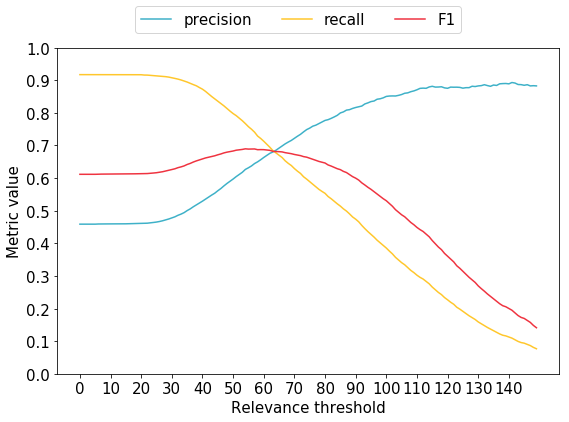

In [6]:
def plot_results(results):
    thresholds = [r[0] for r in results]
    results = [r[1] for r in results]
    plt.figure(figsize=(9,6))
    plt.rcParams.update({'font.size': 15})
    plt.plot(thresholds, [r.get(dfk.EVAL_PREC) for r in results], color='#3eb1c8')
    plt.plot(thresholds, [r.get(dfk.EVAL_REC) for r in results], color='#ffc72c')
    plt.plot(thresholds, [r.get(dfk.EVAL_F1) for r in results], color='#ef3340')
    plt.xticks(thresholds[0::10])
    plt.yticks([i / 10 for i in range(11)])
    plt.legend(['precision', 'recall', 'F1'], bbox_to_anchor=(0.82, 1.15), ncol=3)
    plt.xlabel('Relevance threshold')
    plt.ylabel('Metric value')
    plt.show()

plot_results(results_simple_threshold)

As expected, as we increase the threshold, precision goes up and recall goes down. Which threshold results in the best F1?

In [7]:
def find_best(results):
    overall = [r[1].get(dfk.EVAL_F1) for r in results]
    index = len(overall) - overall[::-1].index(max(overall)) - 1
    return index, results[index][0], results[index][1].get(dfk.EVAL_PREC), \
        results[index][1].get(dfk.EVAL_REC), results[index][1].get(dfk.EVAL_F1)

def print_best(results):
    index, threshold, precision, recall, f1 = find_best(results)
    print('Maximum F1 ({:.4f}) is for threshold {}'.format(f1, threshold))
    print('Precision for this threshold: {:.4f}'.format(precision))
    print('Recall for this threshold: {:.4f}'.format(recall))

print_best(results_simple_threshold)

Maximum F1 (0.6898) is for threshold 54
Precision for this threshold: 0.6266
Recall for this threshold: 0.7671


We can see that threshold 54 results in the best F1 (68.98%).

It is important to note that these threshold values depend on the citation styles and their distribution in the artificial dataset, which might be different from the distribution in the actual system. Of course this wouldn't matter, if the differences between the styles were tiny. To test this, let's check which threshold values would be chosen for each style separately:

In [8]:
dataset_sbm = read_artificial_data('sbm')
datasets_styles = [[d for d in dataset_sbm if d['style'] == s] for s in STYLES]
results_threshold_styles = [[(t, LinkMetricsResults(modify_simple_threshold(d, t)))
                             for t in range(150)]
                            for d in datasets_styles]
best_threshold_styles = [find_best(r)[1] for r in results_threshold_styles]

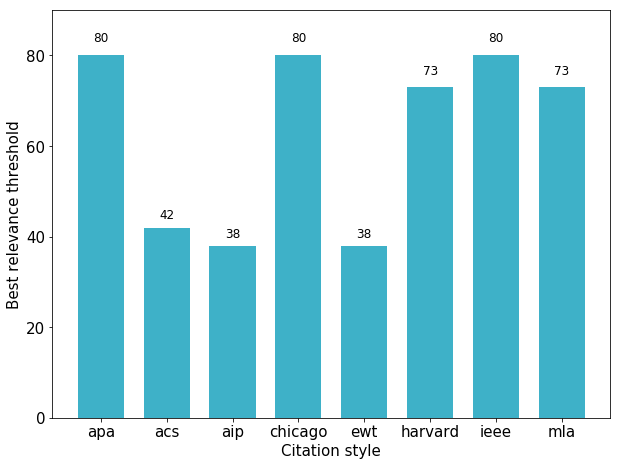

In [9]:
def autolabel(ax, rects, size=12):
    for rect in rects:
        plt.rcParams.update({'font.size': size})
        height = rect.get_height()
        text = '{:.2f}'.format(height)
        text = re.sub('\.00$', '', text)
        ax.text(rect.get_x() + rect.get_width()/2., 1.03*height, text, ha='center', va='bottom')

def plot_threshold_by_styles(best, ylim_max, yticks):
    ind = np.arange(len(STYLES))
    width = 0.7
    
    plt.rcParams.update({'font.size': 15})
    fig, ax = plt.subplots(figsize=(10, 7.5))
    rects = ax.bar(ind + 0.5*width, best, width, color='#3eb1c8')

    ax.set_xlabel('Citation style')
    ax.set_ylabel('Best relevance threshold')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(STYLES_ABR)
    plt.ylim(0, ylim_max)
    plt.yticks(yticks)
    autolabel(ax, rects)
    plt.show()

plot_threshold_by_styles(best_threshold_styles, 90, [0, 20, 40, 60, 80])

Unfortunately, there is a lot of variation between the styles. It seems that for the styles with the title the best threshold is roughly twice as high as the best threshold for the styles without the title. This is most likely related to the amount of information available to the search engine when selecting the target document. Large differences in the best thresholds suggest that using a single threshold for every case might not be the best idea, because most of the time the chosen threshold (54) will be far from the true best threshold.

#### SBM with a normalized threshold

The idea behind the normalized threshold came from the observation, that the relevance scores tend to be higher for longer queries, irrespective of the actual relevance of the returned items.

Let's do a simple test to find out whether the relevance scores are correlated with the query length. We will query the search engine using an example query, and then query it again using the concatenation of the query with itself:

In [10]:
remote_call('https://api.crossref.org/works?' +
            'query.bibliographic=dominika+tkaczyk+cermine&rows=1&select=title,score')[2]

'{"status":"ok","message-type":"work-list","message-version":"1.0.0","message":{"facets":{},"total-results":2417,"items":[{"title":["Extracting Contextual Information from Scientific Literature Using CERMINE System"],"score":24.696714}],"items-per-page":1,"query":{"start-index":0,"search-terms":null}}}'

In [11]:
remote_call('https://api.crossref.org/works?' +
            'query.bibliographic=dominika+tkaczyk+cermine+dominika+tkaczyk+cermine&rows=1' +
            '&select=title,score')[2]

'{"status":"ok","message-type":"work-list","message-version":"1.0.0","message":{"facets":{},"total-results":2417,"items":[{"title":["Extracting Contextual Information from Scientific Literature Using CERMINE System"],"score":49.39343}],"items-per-page":1,"query":{"start-index":0,"search-terms":null}}}'

As we can see, in the second case the relevance score is 100% larger than the score in the first case, even though we simply provided the same query twice, without even passing more information.

Based on this observation, it seems that instead of using a simple threshold, a better approach might be to normalize the relevance score by the length of the reference string before applying the threshold. More precisely, we will apply a threshold to the relevance score divided by the length of the reference string. This function will modify the dataset according to this **normalized threshold**:

In [12]:
def modify_norm_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None \
            and item[dfk.DATASET_SCORE]/len(item[dfk.DATASET_REF_STRING]) < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

Similarly as before, we will calculate the results for a range of different values of the normalized threshold and find out which normalized threshold is the best one:

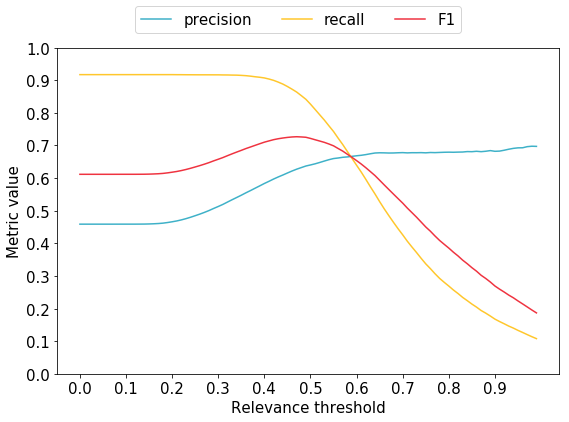

Maximum F1 (0.7268) is for threshold 0.47000000000000003
Precision for this threshold: 0.6273
Recall for this threshold: 0.8639


In [13]:
dataset_sbm = read_artificial_data('sbm')
results_norm_threshold = [(t, LinkMetricsResults(modify_norm_threshold(dataset_sbm, t)))
                          for t in np.arange(0.0, 1.0, 0.01)]
plot_results(results_norm_threshold)
print_best(results_norm_threshold)

The best value of F1 (72.68%) is achieved by the normalized threshold of 0.47. Note that this time we achieved better F1 than in the case of the simple threshold (68,98%).

Similarly as before, let's also plot the normalized threshold for each style separately.

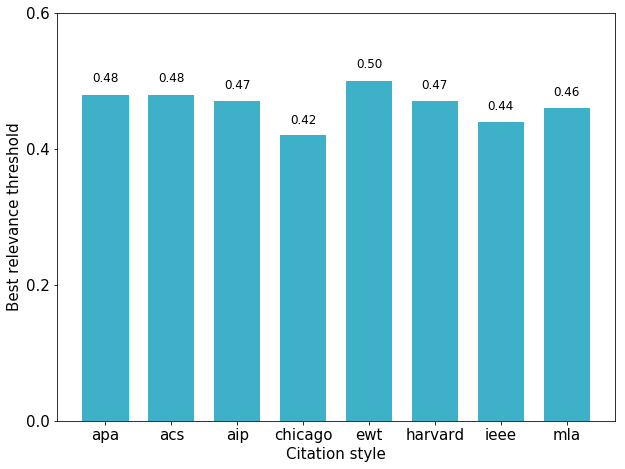

In [14]:
dataset_sbm = read_artificial_data('sbm')
datasets_styles = [[d for d in dataset_sbm if d['style'] == s] for s in STYLES]
results_threshold_norm_styles = \
    [[(t, LinkMetricsResults(modify_norm_threshold(d, t))) for t in np.arange(0.0, 1.0, 0.01)]
     for d in datasets_styles]
best_threshold_norm_styles = [int(find_best(r)[1] * 100)/100.0
                              for r in results_threshold_norm_styles]
plot_threshold_by_styles(best_threshold_norm_styles, 0.6, [0, 0.2, 0.4, 0.6])

In this case we observe much less variability than in the case of the simple threshold. The best normalized threshold varies in a fairly small range 0.42-0.50. As a result, when we use a single normalized threshold, we are closer to the true threshold, irrespective of the style of the reference string.

#### SBMV with a validation threshold

The modified SBMV algorithm requires two thresholds: the relevance threshold for selecting the candidates and the **validation threshold** used to decide whether the chosen target document is similar enough to the reference string and should be returned.

Based on the previous analysis, the normalized threshold of 0.4 was used as the relevance threshold for candidate selection. This a slightly lower value than the best normalized threshold calculated before. In this case a slightly lower value should result in selecting more candidates, which increases the true positives rate. The second validation stage, along with the validation threshold, will make sure to keep the rate of false positives low.

Let's see how the validation threshold affects the results of SBMV algorithm.

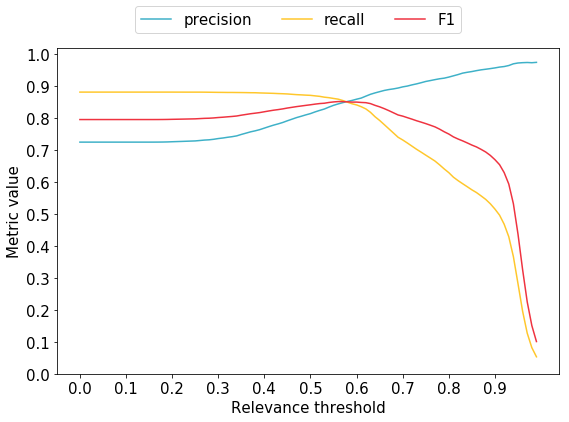

Maximum F1 (0.8517) is for threshold 0.56
Precision for this threshold: 0.8443
Recall for this threshold: 0.8592


In [15]:
dataset_sbmv = read_artificial_data('sbmv')
results_valid_threshold = [(t, LinkMetricsResults(modify_simple_threshold(dataset_sbmv, t)))
                    for t in np.arange(0.0, 1, 0.01)]
plot_results(results_valid_threshold)
print_best(results_valid_threshold)

The best F1 is achieved for threshold of 0.56. We can also see that the F1 achieved for the best threshold is significantly higher than the best F1 for the best normalized threshold (85.17% vs. 72.68%).

Similarly as before, let's also plot the validation threshold the would be chosen for each style.

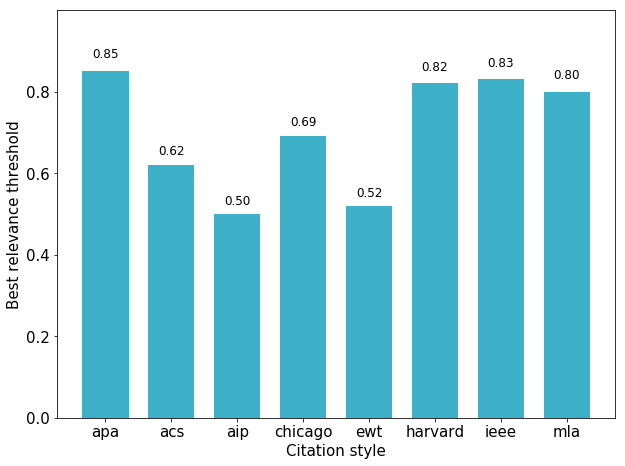

In [16]:
dataset_sbmv = read_artificial_data('sbmv')
datasets_styles = [[d for d in dataset_sbmv if d['style'] == s] for s in STYLES]
results_threshold_valid_styles = \
    [[(t, LinkMetricsResults(modify_simple_threshold(d, t))) for t in np.arange(0.0, 1, 0.01)]
     for d in datasets_styles]
best_threshold_valid_styles = [int(find_best(r)[1] * 100)/100.0
                               for r in results_threshold_valid_styles]
plot_threshold_by_styles(best_threshold_valid_styles, 1, [0, 0.2, 0.4, 0.6, 0.8])

In this case, again we have some variability between the styles, but less correlation with the string length. It might be a good idea to use the style classifier and apply different validation threshold depending on its outcome.

#### Comparison of algorithms

Let's also compare the overall F1 and F1 for each style obtained by three versions of the algorithm: SBM with the best simple threshold, SBM with the best normalized threshold and SBMV with the best validation threshold.

Here we have F1s for the best simple threshold (54):

In [17]:
_, threshold_simple, _, _, f1_simple = find_best(results_simple_threshold)
dataset = read_artificial_data('sbm')
modify_simple_threshold(dataset, threshold_simple)
styles_simple_f1 = [LinkMetricsResults([d for d in dataset if d['style'] == s]).get(dfk.EVAL_F1)
                    for s in STYLES]

And here we have F1s for the best normalized threshold (0.47):

In [18]:
_, threshold_norm, _, _, f1_norm = find_best(results_norm_threshold)
dataset = read_artificial_data('sbm')
modify_norm_threshold(dataset, threshold_norm)
styles_norm_f1 = [LinkMetricsResults([d for d in dataset if d['style'] == s]).get(dfk.EVAL_F1)
                  for s in STYLES]

Finally, SBMV with the normalized threshold of 0.4 and the best validation threshold (0.56):

In [19]:
_, threshold_valid, _, _, f1_valid = find_best(results_valid_threshold)
dataset = read_artificial_data('sbmv')
modify_simple_threshold(dataset, threshold_valid)
styles_valid_f1 = [LinkMetricsResults([d for d in dataset if d['style'] == s]).get(dfk.EVAL_F1)
                   for s in STYLES]

Let's plot those F1s. Here, the first bar represents overall F1, and the following bars are for individual styles.

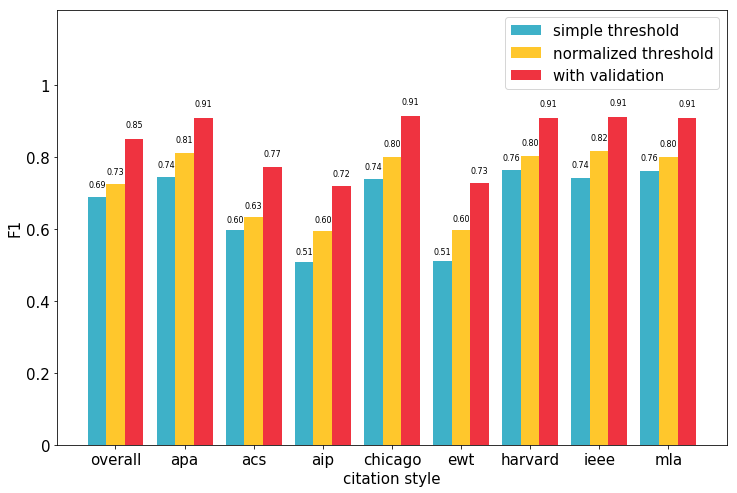

In [20]:
ind = np.arange(len(STYLES) + 1)
width = 0.27

plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(ind - 0.5*width, [f1_simple] + styles_simple_f1, width, color='#3eb1c8')
rects2 = ax.bar(ind + 0.5*width, [f1_norm] + styles_norm_f1, width, color='#ffc72c')
rects3 = ax.bar(ind + 1.5*width, [f1_valid] + styles_valid_f1, width, color='#ef3340')

ax.set_xlabel('citation style')
ax.set_ylabel('F1')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(['overall'] + STYLES_ABR)
plt.ylim(0, 1.21)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.legend((rects1[0], rects2[0], rects3[0]),
          ('simple threshold', 'normalized threshold', 'with validation'))
autolabel(ax, rects1, 8)
autolabel(ax, rects2, 8)
autolabel(ax, rects3, 8)
plt.show()

We can see that SBMV is the best approach outperforming all variants of SBM for all styles. In all cases applying the best normalized threshold results in higher F1 as compared to applying the best simple threshold. 

### Real dataset

The dataset composed of real-life reference strings contains 1000 cases:

In [21]:
def read_real_data(algorithm):
    return read_json(DATA_DIR + 'existing/unstructured_1K_' + algorithm + '.json') \
        [dfk.DATASET_DATASET]

dataset = read_real_data('sbm')
print('Dataset size: {}'.format(len(dataset)))

Dataset size: 1000


Let's examine the results of SBM calculated on the real dataset for a range of simple threshold values:

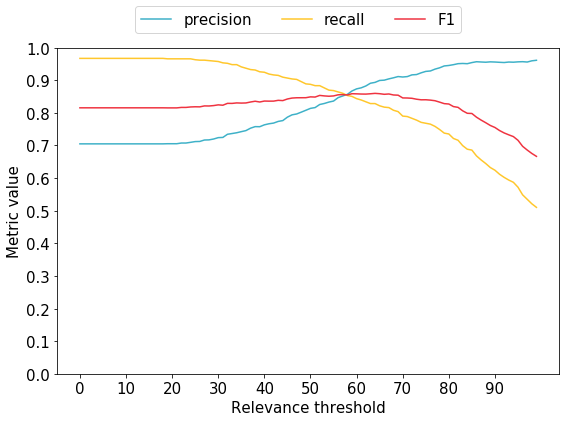

Maximum F1 (0.8598) is for threshold 64
Precision for this threshold: 0.8935
Recall for this threshold: 0.8285


In [22]:
dataset_sbm = read_real_data('sbm')
results_simple_threshold = [(t, LinkMetricsResults(modify_simple_threshold(dataset_sbm, t)))
                            for t in np.arange(0, 100, 1)]
plot_results(results_simple_threshold)
print_best(results_simple_threshold)

The best F1 is achieved for threshold of 64. The F1 line is fairly flat, which suggests that in the real dataset the relevance scores of the correct and incorrect cases are quite well separated.

Let's also see which normalized threshold is the best for the real dataset:

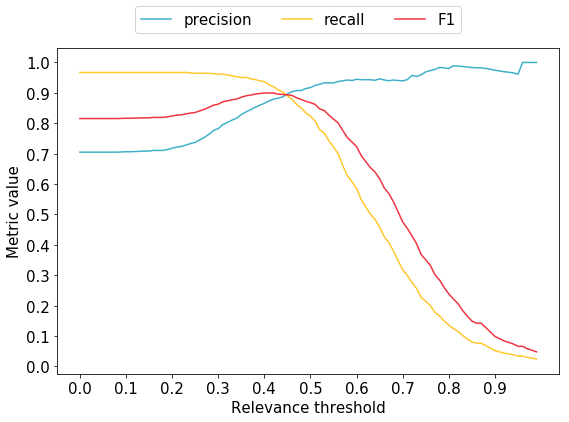

Maximum F1 (0.8999) is for threshold 0.4
Precision for this threshold: 0.8657
Recall for this threshold: 0.9369


In [23]:
dataset_sbm = read_real_data('sbm')
results_norm_threshold = [(t, LinkMetricsResults(modify_norm_threshold(dataset_sbm, t)))
                          for t in np.arange(0.0, 1.0, 0.01)]
plot_results(results_norm_threshold)
print_best(results_norm_threshold)

In this case, we have the best normalized threshold of 0.4. Similarly as before, F1 for the best normalized threshold is higher than F1 for simple threshold.

Finally, let's calculate the best validation threshold for SBMV algorithm for this dataset:

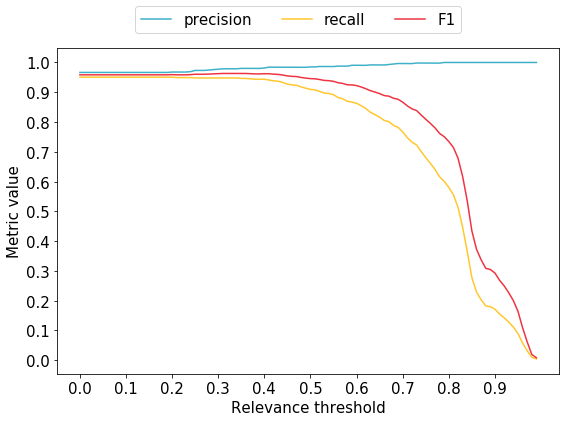

Maximum F1 (0.9631) is for threshold 0.34
Precision for this threshold: 0.9788
Recall for this threshold: 0.9479


In [24]:
dataset_sbmv = read_real_data('sbmv')
results_valid_threshold = [(t, LinkMetricsResults(modify_simple_threshold(dataset_sbmv, t)))
                           for t in np.arange(0.0, 1.0, 0.01)]
plot_results(results_valid_threshold)
print_best(results_valid_threshold)

The best threshold is 0.34. It is smaller than the best validation threshold for artificial data; the reason is most likely much more noise (typos, missing information) the the real dataset.

Finally, let's compare precision, recall and F1 for the best versions of all three algorithms: SBM with a simple threshold, SBM with a normalized threshold, SBMV.

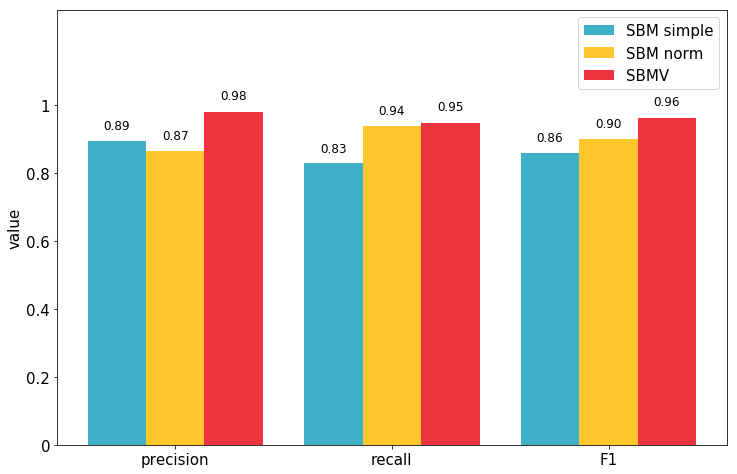

In [25]:
ind = np.arange(3)
width = 0.27

plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(ind - 0.5*width, find_best(results_simple_threshold)[2:], width, color='#3eb1c8')
rects2 = ax.bar(ind + 0.5*width, find_best(results_norm_threshold)[2:], width, color='#ffc72c')
rects3 = ax.bar(ind + 1.5*width, find_best(results_valid_threshold)[2:], width, color='#ef3340')

ax.set_ylabel('value')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(['precision', 'recall', 'F1'])
plt.ylim(0, 1.28)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.legend((rects1[0], rects2[0], rects3[0]), ('SBM simple', 'SBM norm', 'SBMV'))
autolabel(ax, rects1)
autolabel(ax, rects2)
autolabel(ax, rects3)
plt.show()